In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
path_clean_power = "./data/clean_competitor_market_prices_power.csv"
path_master_market = "./data/master_market.csv"

In [4]:
dtypes = {"date_valid_from": str, "date_valid_to": str, "consumption_range_kwh": np.int32, "price_year_eur": np.float64, "post_code": str}
usecols = [name for name, _ in dtypes.items()]

In [5]:
household = pd.read_csv(path_clean_power, usecols=usecols, dtype = dtypes)

In [131]:
market = pd.read_csv(path_master_market, header = [0], parse_dates=["date"]).drop("Unnamed: 0", axis=1)
market.set_index("date", inplace = True)

In [181]:
market.interpolate(method = "time", axis = 0, inplace = True)

In [7]:
household.head()

,date_valid_to,date_valid_from,post_code,consumption_range_kwh,price_year_eur
0,2021-09-01,2021-06-02,14480,3500,878.86
1,2021-09-01,2021-06-09,14480,2800,678.69
2,2021-09-01,2021-07-10,14480,7500,2022.68
3,2021-09-01,2021-07-10,14480,7800,2108.47
4,2021-09-01,2021-07-10,14480,8000,2165.66


In [8]:
household["date_valid_to"].replace({"9999-12-31": "2022-10-15"}, inplace=True)
household["price_kwh"] = household["price_year_eur"]/household["consumption_range_kwh"]

In [9]:
household["date_valid_from"] = pd.to_datetime(household["date_valid_from"])
household["date_valid_to"] = pd.to_datetime(household["date_valid_to"])

In [10]:
print(f"Earliest date: {household['date_valid_from'].min()}" +
f"Latest date: {household['date_valid_to'].max()}")

Earliest date: 2021-05-25 00:00:00Latest date: 2022-10-15 00:00:00


In [28]:
postCodes = household.post_code.unique()

In [11]:
household.head()

,date_valid_to,date_valid_from,post_code,consumption_range_kwh,price_year_eur,price_kwh
0,2021-09-01,2021-06-02,14480,3500,878.86,0.251103
1,2021-09-01,2021-06-09,14480,2800,678.69,0.242389
2,2021-09-01,2021-07-10,14480,7500,2022.68,0.269691
3,2021-09-01,2021-07-10,14480,7800,2108.47,0.270317
4,2021-09-01,2021-07-10,14480,8000,2165.66,0.270707


In [23]:
def queryRangePostCode(df_power, consumption_range_kwh = 2000, post_code = "81737") -> pd.DataFrame:
    res = df_power.loc[(df_power.consumption_range_kwh == consumption_range_kwh) & (df_power.post_code == post_code)].copy()
    
    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        #Aggregating for mean household prices per day
        res = res.groupby('valid_range').agg({'price_kwh':'mean'})
    return res

In [24]:
df = queryRangePostCode(household, 2000, "81737")

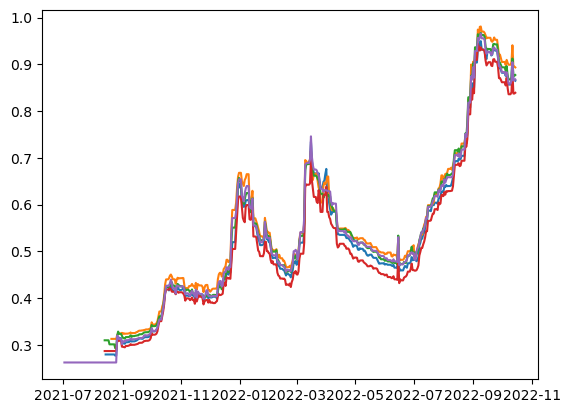

In [36]:
dfs = [(x, queryRangePostCode(household, 2000, x)) for x in postCodes[0:5]]
for PLZ, df in dfs:
    plt.plot(df)
    

In [133]:
df.head()

,price_kwh
valid_range,
2021-07-02,0.26214
2021-07-03,0.26214
2021-07-04,0.26214
2021-07-05,0.26214
2021-07-06,0.26214


In [132]:
market.head()

,spot,d00,d01,d02,d03,d04,d05,d06,w00,w01,...,q04,q05,q06,q07,y01,y02,y03,y04,y05,y06
date,,,,,,,,,,,,,,,,,,,,,
2017-07-01,28.445000,28.45,24.18,32.42,34.89,38.70,39.12,38.50,32.84,34.56,...,28.55,32.37,31.84,25.36,31.05,28.26,28.35,29.57,30.54,31.39
2017-07-02,24.175000,24.18,32.42,34.89,38.70,39.12,38.50,NaN,32.84,34.56,...,28.55,32.37,31.84,25.36,31.05,28.26,28.35,29.57,30.54,31.39
2017-07-03,32.421250,32.42,34.89,38.70,39.12,38.50,NaN,NaN,32.84,34.56,...,28.55,32.37,31.84,25.36,31.05,28.26,28.35,29.57,30.54,31.39
2017-07-04,34.887083,34.89,38.84,38.75,38.50,33.25,28.75,38.00,35.06,34.39,...,28.63,32.82,32.06,25.57,31.29,28.46,28.55,29.73,30.70,31.55
2017-07-05,38.835417,38.84,39.36,38.00,33.25,29.49,37.44,36.69,35.18,33.33,...,28.78,32.69,32.17,25.74,31.31,28.55,28.67,29.89,30.86,31.71


In [ ]:
hh_av = pd.DataFrame(pd.date_range("2021-05-25", "2022-10-15"), columns=["date"])
hh_av["av_price_kwh"] = 0
hh_av["counter"] = 0
hh_av.head()

In [ ]:
for row in household.index:
    for day in pd.date_range(household.date_valid_from.iloc[row], household.date_valid_to.iloc[row]):
        hh_av_row = hh_av.loc[hh_av["date"] == day].index
        hh_av.loc[hh_av_row,"av_price_kwh"] += household.loc[row, "price_kwh"]
        hh_av.loc[hh_av_row, "counter"] += 1

hh_av["av_price_kwh"] = hh_av["av_price_kwh"]/hh_av["counter"]

# Data Wrangling

In [159]:
def getXValues(date, df = market):
    try:
        date = pd.to_datetime(date)
    except:
        raise ValueError("Incorrect Date Format")

    delta = lambda x: pd.Timedelta(x, "days")
    df = df.loc[date - delta(20) : date - delta(1)]
    df = df.filter(["spot", "d01", "d02", "M01", "M02", "M03", "q01", "q02", "y01", "y02"])
    
    return df

In [186]:
getXValues(df.iloc[200,].name)

,spot,d01,d02,M01,M02,M03,q01,q02,y01,y02
date,,,,,,,,,,
2021-12-29,155.603333,73.26,46.07,236.76,331.67,238.78,267.00,193.80,219.88,125.14
2021-12-30,73.262083,12.13,75.33,221.44,293.65,210.40,172.76,176.65,120.11,87.03
2021-12-31,12.127917,29.74,75.72,293.65,210.40,188.97,172.76,176.65,120.11,87.03
2022-01-01,82.578333,47.35,76.11,250.00,195.00,175.44,163.03,168.00,121.63,89.20
2022-01-02,47.353750,76.11,153.92,250.00,195.00,175.44,163.03,168.00,121.63,89.20
2022-01-03,76.107083,153.92,105.90,250.00,195.00,175.44,163.03,168.00,121.63,89.20
2022-01-04,153.916667,107.87,185.03,271.00,228.17,203.46,193.63,199.50,139.88,96.89
2022-01-05,107.868333,194.10,171.03,257.10,214.33,195.99,183.93,189.25,134.70,96.34
2022-01-06,194.097500,167.18,153.33,260.00,221.70,198.67,186.58,191.00,133.00,94.85


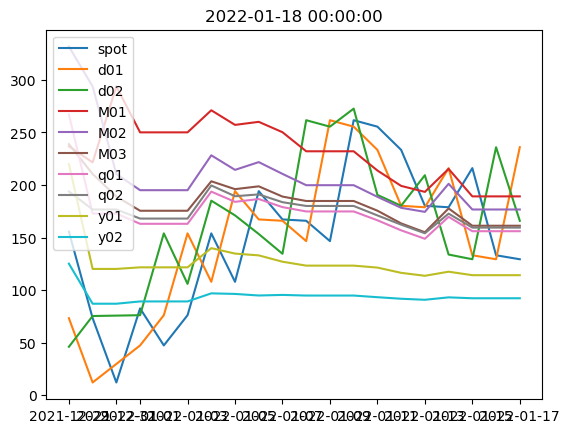

In [185]:
date = df.iloc[200,].name
data = getXValues(date)
plt.plot(data, label = data.columns)
plt.title(str(date))
plt.legend()

# Neural Network Build

In [38]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

2023-01-10 11:45:26.711712: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [164]:
rnn = tf.keras.Sequential()
rnn.add(layers.Input(shape = (20,10,)))
rnn.add(layers.LSTM(units = 20))
rnn.add(layers.Dense(20))
rnn.add(layers.Dense(1, activation = "sigmoid"))


In [92]:
rnn.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [95]:
rnn.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 20)                2080      
                                                                 
 dense_26 (Dense)            (None, 20)                420       
                                                                 
 dense_27 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________


In [98]:
y_train = lambda x: queryRangePostCode(household, post_code=postCodes[x])

In [ ]:
rnn.fit(X_train, y_train, epochs=5)